# Optimizing UBI policy with a flat income tax

Start with a flat income tax, eliminating all deductions, credits, payroll taxes, AMT, and non-health benefit programs. Take that pile of money and adapt the amounts per age group to optimize for disruption and inequality.

*Data: CPS  |  Tax year: 2019  |  Type: Static  |  Author: Max Ghenis*

## Setup

### Imports

In [1]:
import taxcalc as tc
import taxcalc_helpers as tch
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import skopt
from skopt import plots as skopt_plots

/home/max/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
tc.__version__

'2.2.0'

### Constants

In [3]:
FIT = 0.5
YEAR = 2019

### Settings

In [4]:
sns.set_style('white')
DPI = 200
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi'] = DPI
mpl.rcParams['figure.figsize'] = 6.4, 4.8  # Default.

In [5]:
mpl.rcParams['font.sans-serif'] = 'Roboto'
mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

# Use Seaborn's default color palette.
# https://stackoverflow.com/q/48958426/1840471 for reproducibility.
sns.set_palette(sns.color_palette())

In [6]:
# Show one decimal in tables.
pd.set_option('precision', 2)

In [7]:
N_CALLS = 500  # Defaults to 100.

### Function to set all tax rates to the same value

In [8]:
def rt(rate, year=YEAR):
    return {year: rate}

In [9]:
RT_ZERO = rt(0)
RT_ONE = rt(1)
RT_ZEROS = rt([0, 0, 0, 0, 0])

Exclude Medicaid and Medicare from both baseline and reform.

In [10]:
MCAID_MCARE_REPEAL_REFORM = {
    'BEN_mcaid_repeal': rt(True),
    'BEN_mcare_repeal': rt(True),
}

In [11]:
REPEAL_DEDUCTIONS_REFORM = {
    'STD': RT_ZEROS,
    'ID_c': RT_ZEROS
}

In [12]:
REPEAL_CREDITS_REFORM = {
    'EITC_c': rt([0, 0, 0, 0]),  # Don't use RT_ZEROS as that's 5 items.
    'CTC_c': RT_ZERO,
    'ACTC_c': RT_ZERO,
    'ODC_c': RT_ZERO,
    'CDCC_c': RT_ZERO,
    'CR_RetirementSavings_hc': RT_ONE,
    'CR_ForeignTax_hc': RT_ONE,
    'CR_ResidentialEnergy_hc': RT_ONE,
    'CR_GeneralBusiness_hc': RT_ONE,
    'CR_MinimumTax_hc': RT_ONE,
    'CR_AmOppRefundable_hc': RT_ONE,
    'CR_AmOppNonRefundable_hc': RT_ONE,
    'CR_SchR_hc': RT_ONE,
    'CR_OtherCredits_hc': RT_ONE,
    'CR_Education_hc': RT_ONE
}

In [13]:
REPEAL_BENEFITS_REFORM = {
    'BEN_ssi_repeal': rt(True),
    'BEN_housing_repeal': rt(True),
    'BEN_snap_repeal': rt(True),
    'BEN_vet_repeal': rt(True),
    'BEN_wic_repeal': rt(True),
    'BEN_oasdi_repeal': rt(True),
    'BEN_ui_repeal': rt(True),
    'BEN_other_repeal': rt(True)
}

In [14]:
REPEAL_PAYROLL_TAX_REFORM = {
    'FICA_ss_trt': RT_ZERO,
    'FICA_mc_trt': RT_ZERO,
    'AMEDT_rt': RT_ZERO
}

In [15]:
def create_fit_reform(rate):
    return {
        'II_rt1': rt(rate),
        'II_rt2': rt(rate),
        'II_rt3': rt(rate),
        'II_rt4': rt(rate),
        'II_rt5': rt(rate),
        'II_rt6': rt(rate),
        'II_rt7': rt(rate),
        'II_rt8': rt(rate),
        'PT_rt1': rt(rate),
        'PT_rt2': rt(rate),
        'PT_rt3': rt(rate),
        'PT_rt4': rt(rate),
        'PT_rt5': rt(rate),
        'PT_rt6': rt(rate),
        'PT_rt7': rt(rate),
        'PT_rt8': rt(rate),
        'CG_nodiff': {2019: True},  # Avoid specifying each CG rate.
        'AMT_rt1': rt(rate),
        'AMT_rt2': rt(0)  # This is the excess rate. Ideally remove AMT.
    }

In [16]:
base_reform = MCAID_MCARE_REPEAL_REFORM

In [17]:
fit_reform = create_fit_reform(FIT)
fit_reform.update(MCAID_MCARE_REPEAL_REFORM)
fit_reform.update(REPEAL_BENEFITS_REFORM)
fit_reform.update(REPEAL_DEDUCTIONS_REFORM)
fit_reform.update(REPEAL_CREDITS_REFORM)
fit_reform.update(REPEAL_PAYROLL_TAX_REFORM)

In [18]:
fit_reform

{'II_rt1': {2019: 0.5},
 'II_rt2': {2019: 0.5},
 'II_rt3': {2019: 0.5},
 'II_rt4': {2019: 0.5},
 'II_rt5': {2019: 0.5},
 'II_rt6': {2019: 0.5},
 'II_rt7': {2019: 0.5},
 'II_rt8': {2019: 0.5},
 'PT_rt1': {2019: 0.5},
 'PT_rt2': {2019: 0.5},
 'PT_rt3': {2019: 0.5},
 'PT_rt4': {2019: 0.5},
 'PT_rt5': {2019: 0.5},
 'PT_rt6': {2019: 0.5},
 'PT_rt7': {2019: 0.5},
 'PT_rt8': {2019: 0.5},
 'CG_nodiff': {2019: True},
 'AMT_rt1': {2019: 0.5},
 'AMT_rt2': {2019: 0},
 'BEN_mcaid_repeal': {2019: True},
 'BEN_mcare_repeal': {2019: True},
 'BEN_ssi_repeal': {2019: True},
 'BEN_housing_repeal': {2019: True},
 'BEN_snap_repeal': {2019: True},
 'BEN_vet_repeal': {2019: True},
 'BEN_wic_repeal': {2019: True},
 'BEN_oasdi_repeal': {2019: True},
 'BEN_ui_repeal': {2019: True},
 'BEN_other_repeal': {2019: True},
 'STD': {2019: [0, 0, 0, 0, 0]},
 'ID_c': {2019: [0, 0, 0, 0, 0]},
 'EITC_c': {2019: [0, 0, 0, 0]},
 'CTC_c': {2019: 0},
 'ACTC_c': {2019: 0},
 'ODC_c': {2019: 0},
 'CDCC_c': {2019: 0},
 'CR_Retirem

## Data

In [19]:
recs = tc.Records.cps_constructor()

Note, don't use `XTOT` because it doesn't match the age variables.

In [20]:
base = tch.calc_df(records=recs, reform=base_reform, year=YEAR, 
                   group_vars=['nu18', 'n1820', 'n21'], group_n65=True,
                   metric_vars=['aftertax_income'])

In [21]:
fit = tch.calc_df(records=recs, reform=fit_reform, year=YEAR, 
                  group_vars='XTOT', metric_vars='aftertax_income')

CTC_c was redefined in release 1.0.0



In [22]:
new_rev_m = (base.aftertax_income_m.sum() - fit.aftertax_income_m.sum())
'This reform would raise $' + str(round(new_rev_m / 1e6, 2)) + 'T.'

'This reform would raise $5.24T.'

Fix person counts to account for `n65>n21` (see [taxdata#317](https://github.com/PSLmodels/taxdata/issues/317)).

In [23]:
base.n21 = base[['n21', 'n65']].max(axis=1)

Define new exclusive age categories for UBI.

In [24]:
base['n'] = base[['nu18', 'n1820', 'n21']].sum(axis=1)
base['n1864'] = base.n - base.nu18 - base.n65

Weight metrics.

In [25]:
tch.add_weighted_metrics(base, ['n', 'nu18', 'n1864', 'n65'])

In [26]:
single_ubi = new_rev_m / base.n_m.sum()
'This reform would fund a single UBI of $' + str(int(round(single_ubi))) + '.'

'This reform would fund a single UBI of $15731.'

In [27]:
n_total_m = base.n_m.sum()

## Functions for simulating UBI

In [28]:
fit.columns

Index(['vet_ben', 'snap_ben', 'e02400', 'mcaid_ben', 'mcare_ben', 'wic_ben',
       's006', 'ssi_ben', 'e02300', 'housing_ben', 'XTOT', 'tanf_ben',
       'expanded_income', 'aftertax_income', 'other_ben', 'market_income',
       'bens', 'tax', 's006_m', 'aftertax_income_m'],
      dtype='object')

In [29]:
br = base.join(fit[['aftertax_income']], lsuffix='_base', rsuffix='_reform')

In [30]:
br['fpl_base_n_m'] = (
    br.aftertax_income_base < tch.fpl(br.n)) * br.n_m

In [31]:
nu18_total_m = br.nu18_m.sum()
n1864_total_m = br.n1864_m.sum()
n65_total_m = br.n65_m.sum()

In [32]:
def calc_ubi_1864(ubi_u18, ubi_65):
    ubi_u18_total_m = ubi_u18 * nu18_total_m
    ubi_65_total_m = ubi_65 * n65_total_m
    ubi_1864_total_m = new_rev_m - ubi_u18_total_m - ubi_65_total_m
    return ubi_1864_total_m / n1864_total_m

Verify that the 18-64 UBI level is the single UBI when the u18 and 65+ UBI levels are both the single UBI.

In [33]:
np.allclose(calc_ubi_1864(single_ubi, single_ubi), single_ubi)

True

In [34]:
def ubi(nu18, ubi_u18, n1864, ubi_1864, n65, ubi_65):
    return (nu18 * ubi_u18) + (n1864 * ubi_1864) + (n65 * ubi_65)

In [35]:
br_slim = br[['nu18', 'n1864', 'n65', 'n', 'n_m', 's006',
              'aftertax_income_base', 'aftertax_income_reform']]

In [36]:
def ubi_sim(ubi_u18, ubi_65):
    res = br_slim.copy(deep=True)
    ubi_1864 = calc_ubi_1864(ubi_u18, ubi_65)
    res['ubi'] = ubi(res.nu18, ubi_u18, res.n1864, ubi_1864, res.n65, ubi_65)
    res['aftertax_income_reform'] = res.aftertax_income_reform + res.ubi
    res['aftertax_income_noneg_base'] = np.maximum(res.aftertax_income_base, 0)
    res['aftertax_income_chg'] = (res.aftertax_income_reform -
                                  res.aftertax_income_base)
    # Check for zeros to avoid 0/0 NaNs.
    res['aftertax_income_pctchg'] = np.where(
        res.aftertax_income_chg == 0, 0,
        res.aftertax_income_chg / res.aftertax_income_noneg_base)
    res['winners_n_m'] = (res.aftertax_income_chg > 0) * res.n_m
    res['fpl_reform_n_m'] = (
        res.aftertax_income_reform < tch.fpl(res.n)) * res.n_m
    return res

In [37]:
def share_losers(ubi_u18=None, ubi_65=None, sim=None):
    if sim is None:
        # Check that the resulting UBI is nonnegative.
        # Returning 1 ensures it won't be chosen as a solution.
        if calc_ubi_1864(ubi_u18, ubi_65) < 0:
            return 1
        sim = ubi_sim(ubi_u18, ubi_65)
    return 1 - sim.winners_n_m.sum() / n_total_m

In [38]:
def share_losers_skopt(ubi_list):
    # Take args as a list: [ubi_u18, ubi_65]
    return share_losers(ubi_list[0], ubi_list[1])

In [39]:
def share_big_losers(ubi_u18=None, ubi_65=None, sim=None):
    if sim is None:
        # Check that the resulting UBI is nonnegative.
        # Returning 1 ensures it won't be chosen as a solution.
        if calc_ubi_1864(ubi_u18, ubi_65) < 0:
            return 1
        sim = ubi_sim(ubi_u18, ubi_65)
    sim['big_losers_n_m'] = (sim.aftertax_income_pctchg < -0.05) * sim.n_m
    return sim.big_losers_n_m.sum() / n_total_m

In [40]:
def share_big_losers_skopt(ubi_list):
    # Take args as a list: [ubi_u18, ubi_65]
    return share_big_losers(ubi_list[0], ubi_list[1])

In [41]:
def neg_median_income(ubi_u18=None, ubi_65=None, sim=None):
    if sim is None:
        # Check that the resulting UBI is nonnegative.
        # Returning 1 ensures it won't be chosen as a solution.
        if calc_ubi_1864(ubi_u18, ubi_65) < 0:
            return 1
        sim = ubi_sim(ubi_u18, ubi_65)
    return -tch.weighted_quantile(sim.aftertax_income_reform, 0.5, sim.n)

In [42]:
def neg_median_income_skopt(ubi_list):
    # Take args as a list: [ubi_u18, ubi_65]
    return neg_median_income(ubi_list[0], ubi_list[1])

In [43]:
def neg_bottom_10p_income(ubi_u18=None, ubi_65=None, sim=None):
    if sim is None:
        # Check that the resulting UBI is nonnegative.
        # Returning 1 ensures it won't be chosen as a solution.
        if calc_ubi_1864(ubi_u18, ubi_65) < 0:
            return 1
        sim = ubi_sim(ubi_u18, ubi_65)
    return -tch.weighted_quantile(sim.aftertax_income_reform, 0.1, sim.n)

In [44]:
def neg_bottom_10p_income_skopt(ubi_list):
    # Take args as a list: [ubi_u18, ubi_65]
    return neg_bottom_10p_income(ubi_list[0], ubi_list[1])

In [45]:
def gini(ubi_u18=None, ubi_65=None, sim=None):
    if sim is None:
        if calc_ubi_1864(ubi_u18, ubi_65) < 0:
            return 1
        sim = ubi_sim(ubi_u18, ubi_65)
    return tch.gini(sim.aftertax_income_reform, sim.n_m)

In [46]:
def gini_skopt(ubi_list):
    return gini(ubi_list[0], ubi_list[1])

## Run a single UBI

In [47]:
sim_single = ubi_sim(single_ubi, single_ubi)

### Calculate baseline metrics

In [48]:
gini_base = tch.gini(sim_single.aftertax_income_base, sim_single.n_m)
gini_base

0.45869344434571396

In [49]:
fpl_base = br.fpl_base_n_m.sum() / n_total_m
fpl_base

0.07287553699023902

In [50]:
median_income_base = tch.weighted_quantile(base.aftertax_income, 0.5,
                                           base.n_m)
median_income_base

56093.083837944105

In [51]:
bottom_10p_income_base = tch.weighted_quantile(base.aftertax_income, 0.1,
                                               base.n_m)
bottom_10p_income_base

19482.70121647197

### Functions for comparing simulations

In [52]:
def sim_opt(gbrt_res):
    return ubi_sim(gbrt_res.x[0], gbrt_res.x[1])

In [53]:
def ubi_amounts(gbrt_res):
    return pd.Series([gbrt_res.x[0], 
                      calc_ubi_1864(gbrt_res.x[0], gbrt_res.x[1]),
                      gbrt_res.x[1]],
                     index=['Child', 'Adult', 'Senior'])

In [54]:
def sim_gini(sim):
    return tch.gini(sim.aftertax_income_reform, sim.n_m)

In [55]:
def sim_median_income(sim):
    return tch.weighted_quantile(sim.aftertax_income_reform, 0.5, sim.n_m)

In [56]:
def sim_bottom_10p_income(sim):
    return tch.weighted_quantile(sim.aftertax_income_reform, 0.1, sim.n_m)

In [57]:
def sim_summary(sim):
    return pd.Series({'Gini % change': sim_gini(sim) / gini_base - 1,
                      'FPL % change': (
                          sim.fpl_reform_n_m.sum() / n_total_m) / fpl_base - 1,
                      'Median income % change': (
                          sim_median_income(sim) / median_income_base - 1),
                      'Bottom 10% income % change': (
                          sim_bottom_10p_income(sim) /
                          bottom_10p_income_base - 1),
                      'Share losers': share_losers(sim=sim),
                      'Share big losers': share_big_losers(sim=sim)
                     }) * 100

### Calculate single-UBI reform metrics

In [58]:
sim_summary(sim_single)

Gini % change                -19.06
FPL % change                 -99.58
Median income % change        31.26
Bottom 10% income % change    40.99
Share losers                  34.55
Share big losers              29.43
dtype: float64

## Optimize

Use gradient boosting, which outperformed the 3 other optimization routines.

In [59]:
calc_ubi_1864(38000, 38000)

562.2592184290353

In [60]:
UBI_MAX = 38000  # Beyond this and you start to get negatives.
param = (0., UBI_MAX)  # Don't set a prior as this ratholes the routines.
params = [param, param]

def ubi_opt(fun):
    return skopt.gbrt_minimize(fun, params, n_jobs=-1, n_calls=N_CALLS,
                               random_state=42)

### % losers

In [61]:
%%capture
# Hide the many warnings that a solution has already been evaluated.
# See https://github.com/scikit-optimize/scikit-optimize/issues/441.
gbrt_losers = ubi_opt(share_losers_skopt)

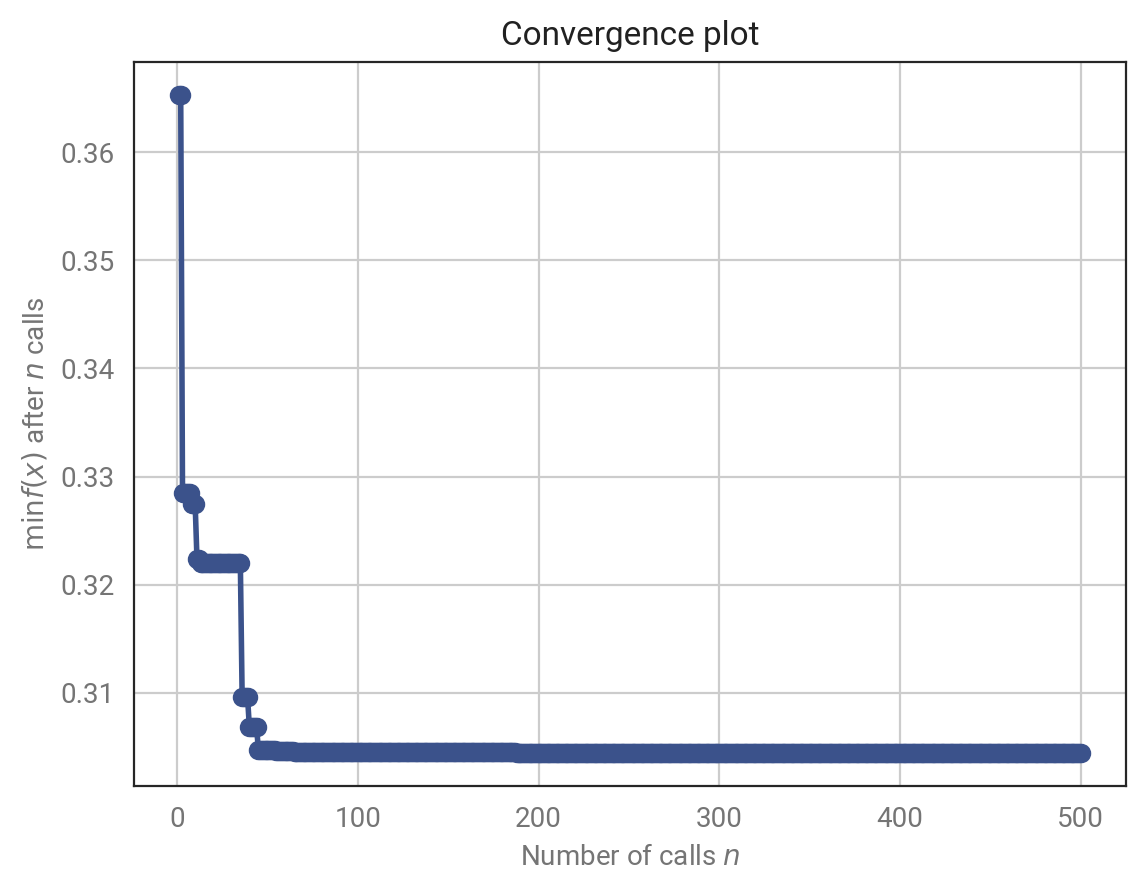

In [62]:
skopt_plots.plot_convergence(gbrt_losers)
plt.show()

In [63]:
ubi_amounts(gbrt_losers)

Child     10326.64
Adult     21986.26
Senior        5.16
dtype: float64

In [64]:
sim_summary(sim_opt(gbrt_losers))

Gini % change                -15.48
FPL % change                 -12.62
Median income % change        33.15
Bottom 10% income % change    13.25
Share losers                  30.44
Share big losers              26.38
dtype: float64

### % big losers

In [65]:
%%capture
gbrt_big_losers = ubi_opt(share_big_losers_skopt)

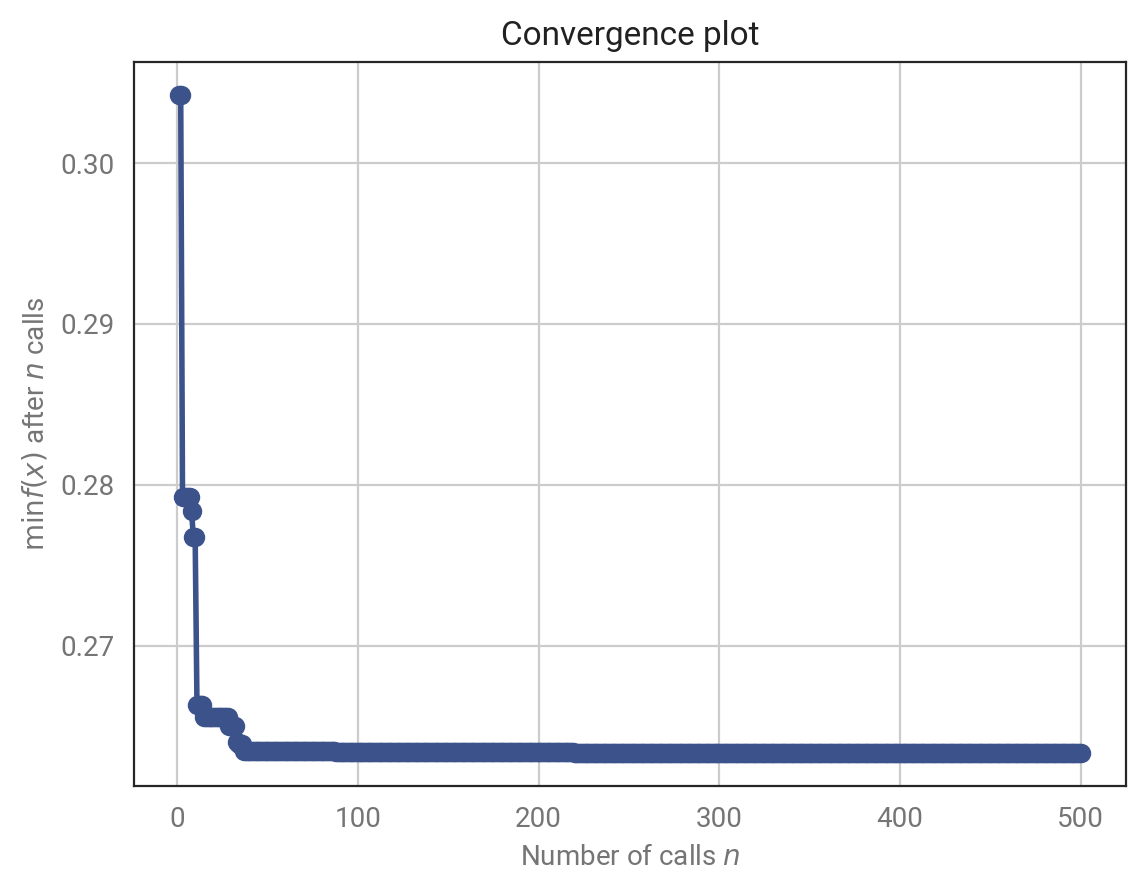

In [66]:
skopt_plots.plot_convergence(gbrt_big_losers)
plt.show()

In [67]:
ubi_amounts(gbrt_big_losers)

Child      8478.48
Adult     22776.88
Senior       34.25
dtype: float64

In [68]:
sim_summary(sim_opt(gbrt_big_losers))

Gini % change                -15.65
FPL % change                 -11.44
Median income % change        31.50
Bottom 10% income % change    17.15
Share losers                  30.57
Share big losers              26.33
dtype: float64

### Gini

In [69]:
%%capture
gbrt_gini = ubi_opt(gini_skopt)

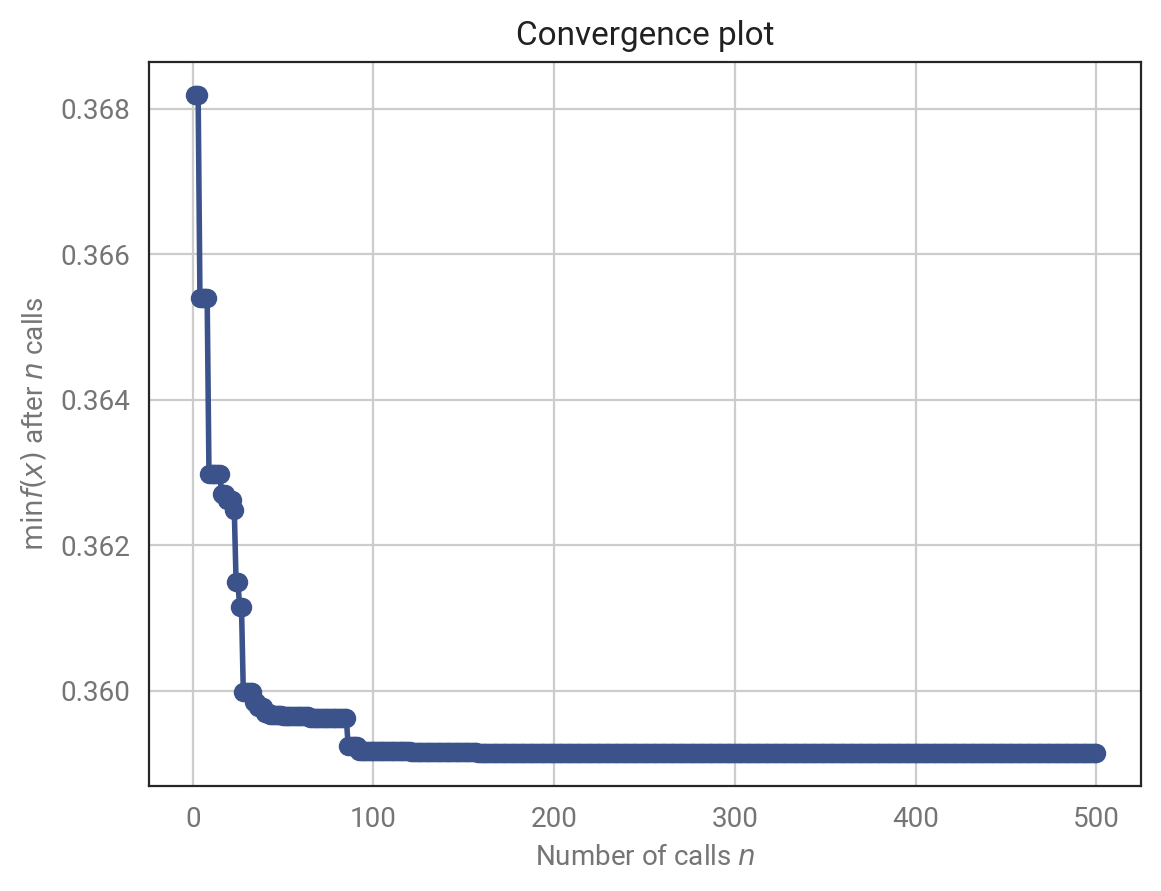

In [70]:
skopt_plots.plot_convergence(gbrt_gini)
plt.show()

In [71]:
ubi_amounts(gbrt_gini)

Child      7265.02
Adult     16860.18
Senior    25855.59
dtype: float64

In [72]:
sim_summary(sim_opt(gbrt_gini))

Gini % change                -21.70
FPL % change                 -94.25
Median income % change        21.88
Bottom 10% income % change    46.50
Share losers                  34.62
Share big losers              27.51
dtype: float64

### Median income

In [73]:
%%capture
gbrt_median_income = ubi_opt(neg_median_income_skopt)

Note this is *negative* median income, as skopt only minimizes.

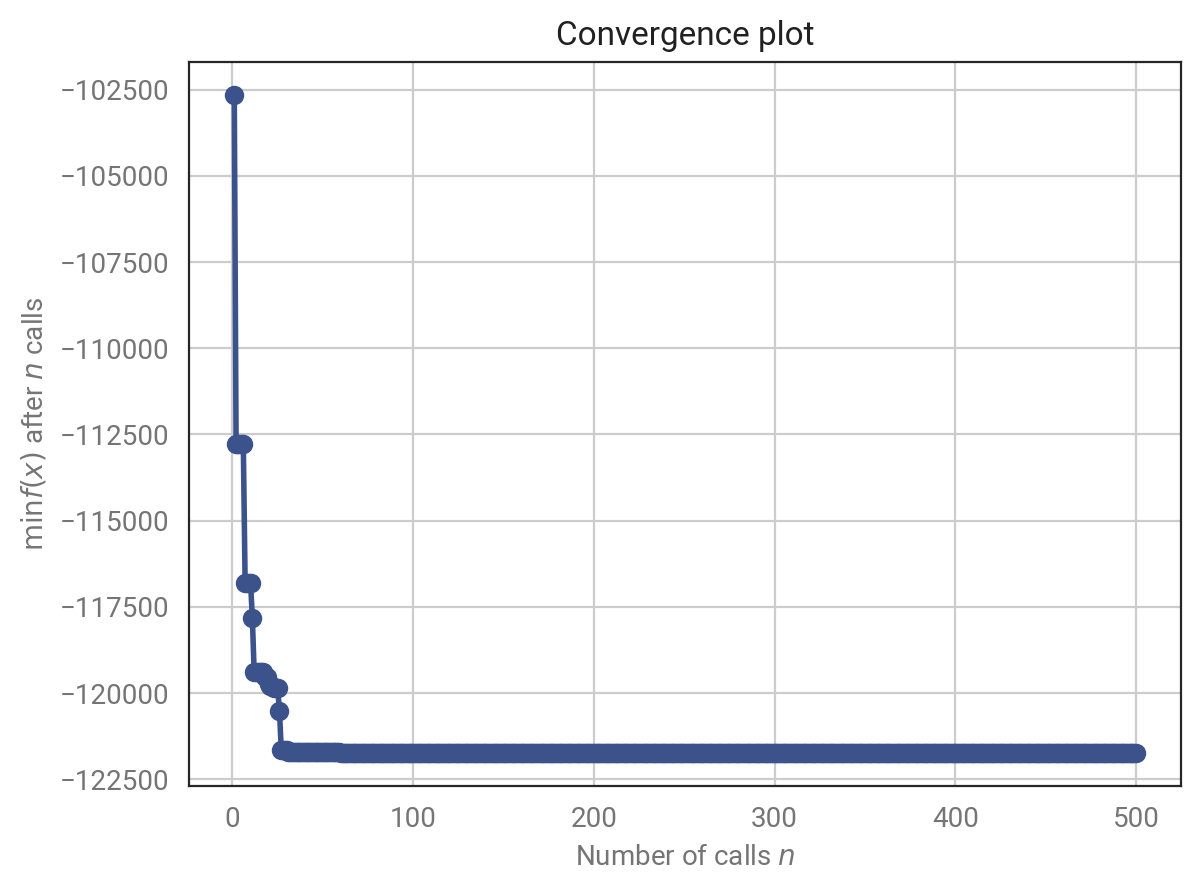

In [74]:
skopt_plots.plot_convergence(gbrt_median_income)
plt.show()

In [75]:
ubi_amounts(gbrt_median_income)

Child     37992.20
Adult     10041.66
Senior        8.97
dtype: float64

In [76]:
sim_summary(sim_opt(gbrt_median_income))

Gini % change                 -3.49
FPL % change                  30.74
Median income % change        43.46
Bottom 10% income % change   -25.25
Share losers                  41.96
Share big losers              39.07
dtype: float64

### Bottom 10% income

In [77]:
%%capture
gbrt_bottom_10p_income = ubi_opt(neg_bottom_10p_income_skopt)

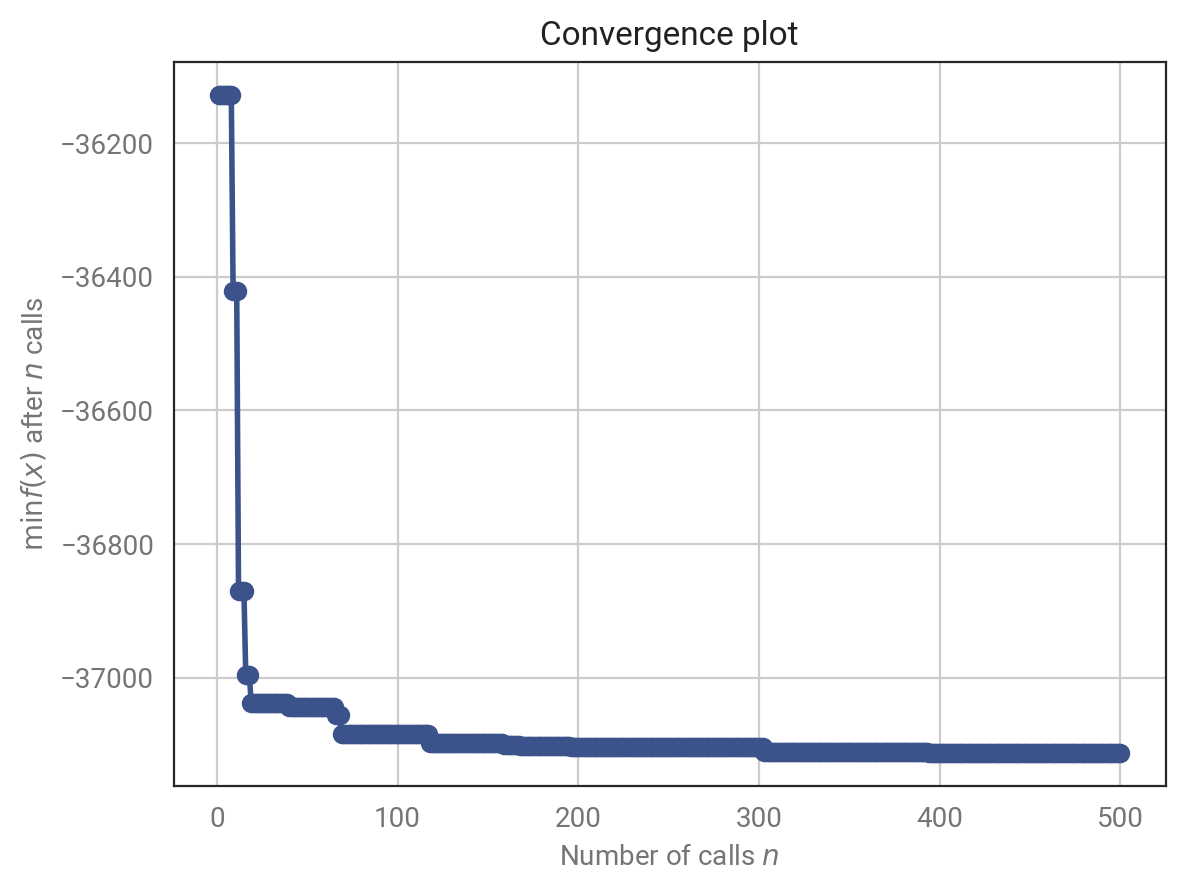

In [78]:
skopt_plots.plot_convergence(gbrt_bottom_10p_income)
plt.show()

In [79]:
ubi_amounts(gbrt_bottom_10p_income)

Child      9980.44
Adult     17156.42
Senior    19968.02
dtype: float64

In [80]:
sim_summary(sim_opt(gbrt_bottom_10p_income))

Gini % change                -21.14
FPL % change                 -95.29
Median income % change        25.43
Bottom 10% income % change    44.82
Share losers                  33.74
Share big losers              27.37
dtype: float64